# Kalman_Testbeam_Np
Kalman Filter




**Author:** Lailin XU  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Friday, April 08, 2022 at 02:28 PM.</small></i>

In [1]:
import os
from math import sqrt, fabs, tan, atan
import ROOT as R
import numpy as np
from numpy.linalg import inv

Assertion failed: p_rcu_reader->depth != 0 (/qemu/include/qemu/rcu.h: rcu_read_unlock: 101)
ldd: exited with unknown exit code (134)


Welcome to JupyROOT 6.26/00


A Tutorial of Kalman Filter for a testbeam experiment or fixed target experiment
=================
Modified from the code by the original author:  Peter Hansen, [link](https://indico.nbi.ku.dk/event/454/contributions/2087)

Demonstrate track fit method for a simple example of horizontal tracks
passing 4 or 6 pixel tracking planes along x, each measuring coordinates (y,z).
A spectrometer magnet is inserted the middle of the telescope.
Everything is in a Helium bag  

y is up
x=0, y=0, z=0 at the first plane.
dy/dx = 0 at the first plane.

here are the planes for a choice of 4 planes with distBetweenPlanes=10.:
 I             I    magnet   I             I
0cm--------- 10cm-----------20cm----------30cm---------->x-axis

RUN CONFIGURATION
=================

In [2]:
rdm = R.TRandom3()
numberOfEvents=1        #number of events to be simulated 
numberOfPlanes=   2        #number of tracking planes on each side of magnet
Cut1=          8.        # cut on chisquared for first 3 hits
Cut2=          8.        # cut on chisquared for next hits
Cut3= (4.*numberOfPlanes-5.)*2.5 # cut on total chisquared
beamMomentum=    0.05    # GeV

SPECTROMETER DESCRIPTION
=================

In [3]:
spectrometerLength=30.   #(cm)
distBetweenPlanes= spectrometerLength/(2.*numberOfPlanes-1.)
pixelSize=  0.002       # (cm)
resolution=  float(0.0006)     #measurement resolution (cm)
tailAmplitude=   0.1     #probability of badly measured hit
tailWidth=   0.0018      #resolution of badly measured hit (cm)

The multiple scattering times momentum per plane is estimated as follows
Rl 50mu Si = 5.3e-4, Rl 50cm He Rl 8.8e-5
multScattAngle=0.0175*sqrt(Rl)*(1+0.125*log(10Rl)/log(10))/sqrt(2)

In [4]:
multScattAngle= 0.0002  # effective theta0*E(GeV) (mult scatt) per plane
thetaxz=        0.0     # incident track angle in the xz plane

There is an adjustable threshold with which we can get the noise occupancy
as low is 10^-7, at a cost in the hit efficiency

In [5]:
noiseOccupancy=  0.00001  # noise probability in readout time window
hitEfficiency =  0.97    # probability for a track to make a hit
                                        #  assume: noise=0.000001 eff=0.93
                                        #                0.00001  eff=0.97
                                        #                0.0001   eff=0.98
                                        #                0.001    eff=0.995

nparameters=         5    # IMPORTANT: set equal to 5 if the field is on to check momentum.

integralBdL=     0.5    # Tesla*cm
magLength=       10.    # cm

xHits=(2*numberOfPlanes)*[0.]    # Distances (x) from first plane
ySize=(2*numberOfPlanes)*[0.]         # Half height of chip
zSize=(2*numberOfPlanes)*[0.]         # Half width of chip

RECONSTRUCTION DATA
=================

In [6]:
yHits=(2*numberOfPlanes)*[[]]  # Measurement coordinates (y) of hits
zHits=(2*numberOfPlanes)*[[]]  # Measurement coordinates (z) of hits
tracks=15*[[]]                 # Info about each reconstructed track

racks[0] vector of z-intercept with plane 0
racks[1] vector of dz/dx at plane 0
racks[2] vector of y-intercept with plane 0
racks[3] vector of dy/dx at plane 0
racks[4] vector of 1/p
racks[5]-tracks[9] same, but truth
racks[10]-tracks[14] errors on the parameters
llthough there is room for 15 tracks,
or now these vectors have only one element. Only one track allowed.

In [7]:
isNoise=(2*numberOfPlanes)*[0.] # MC truth flag for each hit

debug=False                       #debug flag
firstDebugEvent=0
lastDebugEvent=20

counts

In [8]:
numberOfReconstructedTracks=0
numberOfGoodReconstructedTracks=0
nTotalHits=                 0
nNoiseHitsOnTrack=          0
numberOfInefficientTracks=0
numberOfRejectedTracks=0
numberOfGoodRejectedTracks=0

Book histograms

In [9]:
h1 = R.TH1F("h1","y0 residuals",100,-.005,.005)
h2 = R.TH1F("h2","z0 residuals",100,-.005,.005)
h3 = R.TH1F("h3","ty residuals",100,-.025,.025)
h4 = R.TH1F("h4","tz residuals",100,-.025,.025)
h5 = R.TH1F("h5","1/p residuals",100,-1./beamMomentum,1./beamMomentum)
h6 = R.TH1F("h6","y0 pull",100,-10.,10.)
h7 = R.TH1F("h7","z0 pull",100,-10.,10.)
h8 = R.TH1F("h8"," ty pull ",100,-10.,10.)
h9 = R.TH1F("h9"," tz pull ",100,-10.,10.)
h10 = R.TH1F("h10"," 1/p pull ",100,-10.,10.)
h11 = R.TH1F("h11"," z chisquared at plane 2 ",80,0.,24.)
h12 = R.TH1F("h12"," z chisquared at plane 3 ",80,0.,24.)
h13 = R.TH1F("h13"," total chisquared ",80,0.,24.)
h14 = R.TH1F("h14"," total chisquared ",80,0.,24.)
h15 = R.TH1F("h15"," z chisquared at plane 4",80,0.,24.)
h16 = R.TH1F("h16"," z chisquared at plane 5",80,0.,24.)

Event simulation
=================

propagate from one plane to the next in a field free region (a simple straight line)

In [10]:
def propagateStraight(firstplane, nextY, nextZ, nextdYdX, nextdZdX):
  
  for j in range(firstplane, firstplane+numberOfPlanes):
    if(debug): print(" propagating track. Now at plane ", j)
    nh=0
    y,z,r=0.,0.,0.

    # track impact in first plane
    if j==firstplane:  
      y=nextY
      z=nextZ
    else:
    # track impact in first plane
      nextY+=distBetweenPlanes*nextdYdX
      nextZ+=distBetweenPlanes*nextdZdX
      y=nextY
      z=nextZ
    
    # add multiple scattering      
    r=rdm.Gaus()/beamMomentum
    nextdYdX+=(r*multScattAngle)           # update angle due to MS
    r=rdm.Gaus()/beamMomentum
    nextdZdX+=(r*multScattAngle)           # update angle due to MS
    if(debug): print(" track y z at plane ", j, " ", y, " ", z, " angles " , nextdYdX, " ", nextdZdX)
    
    r=rdm.Uniform()
 
    # If this gives a hit
    if (r<hitEfficiency and fabs(nextY)<ySize[j] and fabs(nextZ)<zSize[j]): 
      # then smear y impact by resolution
      r1=rdm.Gaus()
      y+=r1*resolution                     

      # sometimes give extra smear
      r1=rdm.Uniform()                     
      if(r1<tailAmplitude):
        # extra smear (resolution tail)
        r2=rdm.Gaus()
        y+=r2*tailWidth                        

      # then smear z impact by resolution
      r3=rdm.Gaus()
      z+=r3*resolution
      # do we need extra smear?
      r3=rdm.Uniform()                      
      if(r3<tailAmplitude):
        # extra smear (resolution tail)
        r2=rdm.Gaus()
        z+=r2*tailWidth                       

      # update vector of y coords in plane j
      yHits[j].append(y)
      # update vector of z coords in plane j
      zHits[j].append(z)

      if(debug): print(" hit ", nh, " at plane ", j, " y " , y , " z " , z , " expect y z ", nextY , " " , nextZ)

      # update noise flag
      isNoise[j].append(0) 
      nh+=1

    # add noise to 500x500 pixel area ( around real hit )
    noise=rdm.Poisson(250000*noiseOccupancy)
    if(noise>0):
      for k in range(noise):
        r=rdm.Uniform()                  # placement of noise hit
        ynoise= y+(r-0.5)*(500.*pixelSize)
        r=rdm.Uniform()
        znoise= z+(r-0.5)*(500.*pixelSize)

        yHits[j].append(ynoise)          # update vector of y coords
        zHits[j].append(znoise)          # update vector of z coords
        isNoise[j].append(1)             # update truth flag
        nh+=1

  return [nextY, nextZ, nextdYdX, nextdZdX]
 

Simulate the event

In [11]:
def propagateTrack():

  # start at plane 0
  nextY=0.
  nextdYdX=0.
  nextZ=0.
  nextdZdX=thetaxz

  # propagate track through the planes before the magnet
  [nextY, nextZ, nextdYdX, nextdZdX] = propagateStraight(0,nextY,nextZ,nextdYdX,nextdZdX)

  #Trace through magnet (to a good approximation),
  dtheta=0.003*integralBdL/beamMomentum
  #from plane 1 to the magnet center
  nextY+=(nextdYdX*distBetweenPlanes/2.)             
  ang=atan(nextdYdX)+dtheta
  #and on to the next plane
  nextY+=(tan(ang)*distBetweenPlanes/2.)             

  # update angle
  nextdYdX=tan(ang)                                  
  nextZ+=(distBetweenPlanes*nextdZdX)

  # propagate track through the planes after the magnet
  [nextY, nextZ, nextdYdX, nextdZdX] = propagateStraight(numberOfPlanes,nextY,nextZ,nextdYdX,nextdZdX)
  

Kalman Filter
=================

In [12]:
def kalmanFilter(p1, ihit, z, C):
  # Propagates a track candidate from detector plane p1-1 to detector plane p1
  # as a straight line in x-z (the non-bending plane)
  # updates the track parameters and their error matrix in x-z
  # returns the chisquared at detector plane p1 for hit number ihit in this plane

  import ROOT as R
 
  s2=resolution*resolution
  #use here a fixed momentum estimate
  pinv = 1./beamMomentum 
  #average multiple scattering angle
  t0=multScattAngle*pinv 
  #propagator F to next plane
  Fz = np.zeros(shape=(2,2))
  FTz = np.zeros(shape=(2,2))
  Fz[0][0]=1
  Fz[0][1]=distBetweenPlanes
  Fz[1][0]=0
  Fz[1][1]=0

  #the transpose of F
  FTz=np.transpose(Fz)

  #multiple scattering contribution to covariance of extrapolation
  Qz = np.zeros(shape=(2,2))

  Qz[0][0]=t0*t0*distBetweenPlanes*distBetweenPlanes
  Qz[0][1]=t0*t0*distBetweenPlanes
  Qz[1][0]=t0*t0*distBetweenPlanes
  Qz[1][1]=t0*t0

  #covariance of extrapolation
  #Cpz = Fz*C*FTz+Qz
  Cpz = np.dot(np.dot(Fz, C), FTz)+Qz

  #predicted state at next plane
  zpred = np.zeros(shape=(2,1))
  #zpred = Fz*z
  zpred = np.dot(Fz, z)

  #covariance matrix of updated state 
  # covariance of the prediction
  Cinv = np.zeros(shape=(2,2))
  # covariance of the measurement
  Minv = np.zeros(shape=(2,2))
  Minv[0][0]=1./s2
  #add weights
  Cinv = inv(Cpz) + Minv 
  C=inv(Cinv)

  #updated track state, use the weighted average of the measurement and the prediction.
  # Note that An equivalent way is to use the Kalman gain matrix K
  znew = np.zeros(shape=(2,1))
  #new z weighted by 1/s2
  znew[0][0] = zHits[p1][ihit]/s2
  znew[1][0]=0.
  #add predicted z - remember Cpz is inverted
  #z=C*(Cpz*zpred + znew)   
  z=np.dot(C, (np.dot(Cpz, zpred) + znew))   

  #the residual and the chisquared (the returned float)
  r =(zHits[p1][ihit]-zpred[0][0])
  #covariance matrix of the residual
  R = s2 + Cpz[0][0]
  chi2=r*r/R
  return [chi2, z, C]


def globalChi2(ihits, x, C):
  #global chi2-fit to x-y hits in 2*numberOfPlanes pixel planes 
  #nparameters=4 indicates that the field is off

  pinv=1./beamMomentum
  # d(momentum)/d(tan(delta_theta))
  dpdt=0.003*integralBdL 
  # MS angle using an estimated 1/p
  t0=multScattAngle*pinv 
  t2=t0*t0
  s2=resolution*resolution
  d2=distBetweenPlanes*distBetweenPlanes
  # number of pixel planes
  nplane=2*numberOfPlanes 
  # 2 times that (z and y measurements)
  ndim=4*numberOfPlanes   
  #
  # The column vector of the measurements
  # - first the nplane z measurements, then the nplane y measurements 
  m = np.zeros(shape=(ndim,1))
  for i in range(nplane):
    m[i][0] = zHits[i][ihits[i]]
    m[i+nplane][0] = yHits[i][ihits[i]]

  #
  # The Covariance matrix of the measurements, including MS induced correlations
  V = np.zeros(shape=(ndim,ndim))

  V[0][0] = s2
  V[nplane][nplane] = s2

  for i in range(1, nplane):
    for j in range(i, nplane):
       V[i][j] = V[i-1][j-1] + i*j*t2*d2
       V[i+nplane][j+nplane] = V[i][j]

       if(j>i):
         V[j][i] = V[i][j]
         V[j+nplane][i+nplane] = V[j][i]

  #
  # The track state vector is defined as
  # x = (z0, z', y0, y', 1/p) with
  # track impact z0, y0 and slopes z'=dz/dx and y'=dy/dx all given at plane 0
  #
  # H projects the track state vector on the measurement base
  H = np.zeros(shape=(ndim,nparameters))

  for i in range(nplane):
    j=i+nplane
    H[i][0]=1
    H[j][2]=1
    H[i][1]=i*distBetweenPlanes
    H[j][3]=i*distBetweenPlanes

    if(i>numberOfPlanes-1 and nparameters>4): H[j][4]=dpdt*distBetweenPlanes*(0.5+i-numberOfPlanes)
  
  HT=np.transpose(H)
  #
  # Now do the linear chi2 fit
  print("Test 0, HT:", HT)
  print("Test 1, V:", V) 
  print("Test 2, H:", H) 
  #Ctmp=HT*inv(V)*H
  Ctmp=np.dot(np.dot(HT, inv(V)), H)
  print("Test 3, Ctmp:", Ctmp)
  C=inv(Ctmp)
  # V is now inverse
  # C is now the covariance matrix of the fitted track state

  # x is the fitted track state vector
  #x = C*HT*V*m
  x = np.dot(np.dot(C, HT), np.dot(V, m))

  # R is the residual vector
  #R=m-H*x
  R=m-np.dot(H, x)
  RT=np.transpose(R)
 
  #Chi2=RT*V*R
  Chi2=np.dot(np.dot(RT, V), R)
  if(debug): print("  chi2 ", Chi2[0][0])
  # Return chi2 for ndim-nparameters d.o.f.
  return [Chi2[0][0], x, C]

econstruct one track in 4 planes
=================

In [13]:
def reco4(ibest, xbest, Cbest):

  chi2min=10000000.
  # First loop over the hits in the first plane
  # =======================================================================
  for i0 in range(len(yHits[0])):
 
    # skip hit in first plane if it is outside the beam profile
    if(fabs(yHits[0][i0])>4.*pixelSize): continue
    allsignal= not isNoise[0][i0]

    # loop over the hits in the second plane
    # =====================================================================
    for i1 in range(len(yHits[1])):

      s2=resolution*resolution
      allsignal= allsignal and (not isNoise[1][i1])
      #consider the xz plane - a non-bending plane
      #track state at plane 1
      z = np.zeros(shape=(2,1))
      z[0][0] = zHits[1][i1]
      z[1][0] = (zHits[1][i1]-zHits[0][i0])/distBetweenPlanes
      #its covariance
      Cz = np.zeros(shape=(2,2))
      Cz[0][0] = s2
      Cz[0][1] = s2/distBetweenPlanes
      Cz[1][0] = Cz[0][1]
      Cz[1][1] = 2*s2/distBetweenPlanes/distBetweenPlanes


      # loop over hits in the third plane
      #===========================================================
      for i2 in range(len(yHits[2])):

        [chi2, z, Cz] = kalmanFilter(2,i2,z,Cz)

        allsignal=allsignal and (not isNoise[2][i2])
        if(allsignal): h11.Fill(chi2)

        if(chi2 > Cut1): continue


        #loop over hits in the fourth plane
        #====================================================================================
        for i3 in range(len(yHits[3])):

          [chi2, z, Cz] = kalmanFilter(3,i3,z,Cz)

          allsignal=allsignal and (not isNoise[3][i3])
          if(allsignal): h12.Fill(chi2)

          if(chi2 >Cut2): continue

          # now we have a track candidate

          # make a global chi2 fit and store only the best track
          # ===============================================================================
          x = np.zeros(shape=(5,1))
          C = np.zeros(shape=(5,5))
          x[4][0] = 1./beamMomentum #use here a fixed momentum estimate
          ihits=[i0,i1,i2,i3]
          [chi2, x, C] = globalChi2(ihits,x,C)

          if(chi2<chi2min):
            ibest[0]=i0
            ibest[1]=i1
            ibest[2]=i2
            ibest[3]=i3
            xbest=x
            Cbest=C
            chi2min=chi2
  return [chi2min, xbest, Cbest]

tore track.
=================

In [14]:
def storeTrack(ibest, xbest, Cbest):
  #
  #fitted z intercept at plane 0
  tracks[0].append(xbest[0])  
  if(debug): print(" z0 ", tracks[0][0])
  #fitted z slope at plane 0
  tracks[1].append(xbest[1]) 
  if(debug): print(" dz/dx " , tracks[1][0] )
  #y intercept at plane 0
  tracks[2].append(yHits[0][ibest[0]]) 
  if(debug): print(" y0 " , tracks[2][0] )
  tracks[3].append( (yHits[1][ibest[1]]-yHits[0][ibest[0]])/distBetweenPlanes )
  if(debug): print(" dy/dx " , tracks[3][0] )
  #charge/momentum
  tracks[4].append(xbest[4])   
  if(debug): print(" 1/p " , tracks[4][0] )
  #truth
  tracks[5].append(0.)
  tracks[6].append(thetaxz)
  tracks[7].append(0.)
  tracks[8].append(0.)
  tracks[9].append(1/beamMomentum)
  #errors
  tracks[10].append(sqrt( Cbest[0] ))
  if(debug): print(" Dz0 " , tracks[10][0] )
  tracks[11].append(sqrt( Cbest[5+1] ))
  if(debug): print(" Ddz/dx " , tracks[11][0] )
  tracks[12].append(sqrt( Cbest[2*5+2]))
  if(debug): print(" Dy0 " , tracks[12][0] )
  tracks[13].append(sqrt(Cbest[3*5+3]))
  if(debug): print(" Ddy/dx " , tracks[13][0] )
  tracks[14].append(sqrt( Cbest[4*5+4] ))
  if(debug): print(" D1/p " , tracks[14][0] )

  h1.Fill( tracks[2][0]-tracks[7][0] )
  h2.Fill( tracks[0][0]-tracks[5][0] )
  h3.Fill( tracks[3][0]-tracks[8][0] )
  h4.Fill( tracks[1][0]-tracks[6][0] )
  h5.Fill( tracks[4][0]-tracks[9][0] )
  h6.Fill( (tracks[2][0]-tracks[7][0])/tracks[12][0] )
  h7.Fill( (tracks[0][0]-tracks[5][0])/tracks[10][0] )
  h8.Fill( (tracks[3][0]-tracks[8][0])/tracks[13][0] )
  h9.Fill( (tracks[1][0]-tracks[6][0])/tracks[11][0] )
  h10.Fill( (tracks[4][0]-tracks[9][0])/tracks[14][0] )

Main Program
=================
geometry

In [15]:
for i in range(2*numberOfPlanes):
  xHits[i]=distBetweenPlanes*i
  ySize[i]=1.
  if(i>numberOfPlanes-1): ySize[i]=2.
  zSize[i]=1.

----------------------------------------------------------------------
Loop over numberOfEvents

In [16]:
for i in range(numberOfEvents):

  if(i > firstDebugEvent-1 ): debug=True
  if(i > lastDebugEvent ): debug=False

  # New event
  if (debug): print(" new event " )
  # reset input and output data buffers
  for j in range(15): tracks[j]=[]
  for j in range(2*numberOfPlanes):
    yHits[j]=[]
    zHits[j]=[]
    isNoise[j]=[]
  
  #========================================================================================
  # Simulate the event
  propagateTrack()

  #========================================================================================
  # Reconstruct the event
  #
  # ---------------------------------------------------------------------------------------
  # Pattern recognition and fit
  #========================================================================================
  #
  reject=False
  # first count number of hits in each plane
  nRealHits=0
  for j in range(2*numberOfPlanes):
    nHits=len(yHits[j])
    for k in range(nHits):
      if(not isNoise[j][k]):
        nRealHits+=1
        break
    nTotalHits+=nHits
    #all the planes must fire
    if(nHits<1): reject=True           
    if (debug): print(" plane " , j , " nHits " , nHits , " nRealHits " , nRealHits )

  if(reject):
    numberOfInefficientTracks+=1
    continue

  if(debug): print(" start reconstruction" )

  # number of accepted track candidates.
  ntracks=0           
  xbest=np.zeros(shape=(5,1))
  Cbest=np.zeros(shape=(5,5))
  ibest=(2*numberOfPlanes)*[0.]

  #Consider all possible combinations of hits to find best combination in xz
  #Only one track is reconstructed and it must have hits in all planes
  chi2min=100000000.
  if(numberOfPlanes>2):
    #chi2min=reco6(ibest,xbest,Cbest)
    continue
  else:
    [chi2min, xbest, Cbest]=reco4(ibest,xbest,Cbest)

  # Reject event if best track not good enough
  if(chi2min>Cut3):
    numberOfRejectedTracks+=1
    if(nRealHits>2*numberOfPlanes-1): numberOfGoodRejectedTracks+=1
    if(debug): print(" best track rejected chi2= " , chi2min )
    continue
  
  h13.Fill(chi2min)

  # Repeat the fit for the selected track (using the measured momentum now)
  [chi2, dummp_x, dummy_C]= globalChi2(ibest,xbest,Cbest)
  h14.Fill(chi2)

  allsignal= True
  for j in range(2*numberOfPlanes): allsignal=allsignal and (not isNoise[j][ibest[j]])

  if(debug):
    if(allsignal):
      print(" Noiseless track selected   chi2 " , chi2 )
    else:
      print(" Noisy track selected   chi2 " , chi2 )

  #Store the track
  p = 5*[0.]
  ep = (5*5)*[0.]
  for ipar in range(5):
    p[ipar]=xbest[ipar][0]
    for jpar in range(5): ep[ipar*5+jpar]=Cbest[ipar][jpar]

  storeTrack(ibest,p,ep)

  ntracks+=1
  numberOfReconstructedTracks+=1          

  if(allsignal): numberOfGoodReconstructedTracks+=1
  for j in range(2*numberOfPlanes):
    if(isNoise[j][ibest[j]]): nNoiseHitsOnTrack+=1
    #flag the hits as used
    yHits[j][ibest[j]]=ySize[j]+1.

 new event 
 propagating track. Now at plane  0
 track y z at plane  0   0.0   0.0  angles  0.003995730870437592   -0.001739057557657361
 hit  0  at plane  0  y  -1.803166279569268e-05  z  -3.403039528741898e-05  expect y z  0.0   0.0
 propagating track. Now at plane  1
 track y z at plane  1   0.03995730870437592   -0.01739057557657361  angles  0.006314616059217591   -0.0032675952631812067
 hit  0  at plane  1  y  0.03946782547792218  z  -0.018949030742854367  expect y z  0.03995730870437592   -0.01739057557657361
 propagating track. Now at plane  2
 track y z at plane  2   0.25318290780714003   -0.05006652820838568  angles  0.0424926304885536   -0.002888623975200531
 hit  0  at plane  2  y  0.25391295932267083  z  -0.05083540780937252  expect y z  0.25318290780714003   -0.05006652820838568
 propagating track. Now at plane  3
 track y z at plane  3   0.678109212692676   -0.078952767960391  angles  0.03266006396739675   -0.003207769693789956
 hit  0  at plane  3  y  0.6779097862846919 

Test 2, H: [[1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [1.00e+00 1.00e+01 0.00e+00 0.00e+00 0.00e+00]
 [1.00e+00 2.00e+01 0.00e+00 0.00e+00 0.00e+00]
 [1.00e+00 3.00e+01 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 1.00e+00 1.00e+01 0.00e+00]
 [0.00e+00 0.00e+00 1.00e+00 2.00e+01 7.50e-03]
 [0.00e+00 0.00e+00 1.00e+00 3.00e+01 2.25e-02]]
Test 3, Ctmp: [[ 2.77902637e+06  6.24578820e+03  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.24578820e+03  6.24859564e+04  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.77902637e+06  6.24578820e+03
  -4.68539063e+00]
 [ 0.00000000e+00  0.00000000e+00  6.24578820e+03  6.24859564e+04
   1.05444977e-02]
 [ 0.00000000e+00  0.00000000e+00 -4.68539063e+00  1.05444977e-02
   7.02887802e-02]]
  chi2  0.021421694184744926
Test 0, HT: [[1.00e+00 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.00e+01 2.00e+01 3.00e+01 0.00e+00 0

In [17]:
print(" Generated Tracks " , numberOfEvents )
print(" Reconstructed Tracks " , numberOfReconstructedTracks )
print(" Reconstructed Tracks without noise hits " , numberOfGoodReconstructedTracks )
print(" Tracks lost due to missing hit " , numberOfInefficientTracks )
print(" Tracks lost to quality cuts " , numberOfRejectedTracks )
print(" Tracks with no noise hits lost to quality cuts " , numberOfGoodRejectedTracks )
print(" Total hits " , nTotalHits )
print(" Used noise hits  " , nNoiseHitsOnTrack )
print(" Hits per track is always " , 2*numberOfPlanes )

 Generated Tracks  1
 Reconstructed Tracks  1
 Reconstructed Tracks without noise hits  0
 Tracks lost due to missing hit  0
 Tracks lost to quality cuts  0
 Tracks with no noise hits lost to quality cuts  0
 Total hits  15
 Used noise hits   3
 Hits per track is always  4


Plot the results (fit parameter - truth),
     the pulls ( (fit parameter - truth)/ parameter error )
     and the chisquared (hit-fit)^2/hit error^2.

In [18]:
R.gStyle.SetOptFit(1011)
R.gStyle.SetErrorX(0)


"""
c1 = R.TCanvas("c1"," intercept ",50,50,800,600)
c1.GetFrame().SetFillColor(0)
c1.GetFrame().SetBorderSize(20)
h1.SetMarkerColor(1)
h1.SetMarkerStyle(20)
h1.GetXaxis().SetTitle(" y0 residual (cm)")
h1.Draw("AP")
h1.Fit("gaus")
h1.Draw("same")

c2 = R.TCanvas("c2"," intercept ",70,70,800,600)
c2.GetFrame().SetFillColor(0)
c2.GetFrame().SetBorderSize(20)
h2.GetXaxis().SetTitle(" z0 residual (cm)")
h2.Draw("AP")
h2.Fit("gaus")
h2.Draw("same")

c3 = R.TCanvas("c3"," y slope ",80,80,800,600)
c3.GetFrame().SetFillColor(0)
c3.GetFrame().SetBorderSize(20)
h3.GetXaxis().SetTitle(" ty residual")
h3.Draw("AP")
h3.Fit("gaus")
h3.Draw("same")

c4 = R.TCanvas("c4"," z slope ",90,90,800,600)
c4.GetFrame().SetFillColor(0)
c4.GetFrame().SetBorderSize(20)
h4.GetXaxis().SetTitle(" tz residual")
h4.Draw("AP")
h4.Fit("gaus")
h4.Draw("same")
"""

c5 = R.TCanvas("c5","1/p",100,100,800,600)
c5.GetFrame().SetFillColor(0)
c5.GetFrame().SetBorderSize(20)
h5.GetXaxis().SetTitle("fitted 1/p residual GeV-1")
h5.Draw()
h5.Fit("gaus")
h5.Draw("same")


c6 = R.TCanvas("c6","y0 pull",120,120,800,600)
c6.GetFrame().SetFillColor(0)
c6.GetFrame().SetBorderSize(20)
h6.GetXaxis().SetTitle("y0 pull")
h6.Draw()
h6.Fit("gaus")
h6.Draw("same")
"""
c7 = R.TCanvas("c7","z0 pull",130,130,800,600)
c7.GetFrame().SetFillColor(0)
c7.GetFrame().SetBorderSize(20)
h7.GetXaxis().SetTitle("z0 pull")
h7.Draw()
h7.Fit("gaus")
h7.Draw("same")
"""
c8 = R.TCanvas("c8","y slope pull",140,140,800,600)
c8.GetFrame().SetFillColor(0)
c8.GetFrame().SetBorderSize(20)
h8.GetXaxis().SetTitle("y slope pull")
h8.Draw()
h8.Fit("gaus")
h8.Draw("same")

"""
c9 = R.TCanvas("c9","z slope pull ",140,140,800,600)
c9.GetFrame().SetFillColor(0)
c9.GetFrame().SetBorderSize(20)
h9.GetXaxis().SetTitle("z slope pull")
h9.Draw()
h9.Fit("gaus")
h9.Draw("same")
"""

c10 = R.TCanvas("c10"," 1/p pull",140,140,800,600)
c10.GetFrame().SetFillColor(0)
c10.GetFrame().SetBorderSize(20)
h10.GetXaxis().SetTitle(" 1/p pull")
h10.Draw()
h10.Fit("gaus")
h10.Draw("same")


c11 = R.TCanvas("c11"," chi2 ",150,150,800,600)
c11.GetFrame().SetFillColor(0)
c11.GetFrame().SetBorderSize(20)
h11.GetXaxis().SetTitle(" chi2(z) at plane 2")
h11.Draw()

"""
c15 = R.TCanvas("c15"," chi2 ",155,155,800,600)
c15.GetFrame().SetFillColor(0)
c15.GetFrame().SetBorderSize(20)
h15.GetXaxis().SetTitle(" chi2(z) at plane 4")
h15.Draw()

c12 = R.TCanvas("c12"," chi2 ",160,160,800,600)
c12.GetFrame().SetFillColor(0)
c12.GetFrame().SetBorderSize(20)
h12.GetXaxis().SetTitle(" chi2(z) at plane 3")
h12.Draw()

c16 = R.TCanvas("c16"," chi2 ",165,165,800,600)
c16.GetFrame().SetFillColor(0)
c16.GetFrame().SetBorderSize(20)
h16.GetXaxis().SetTitle(" chi2(z) at plane 5")
h16.Draw()
"""

c13 = R.TCanvas("c13"," chi2 ",170,170,800,600)
c13.GetFrame().SetFillColor(0)
c13.GetFrame().SetBorderSize(20)
h13.GetXaxis().SetTitle(" global chi2 with fixed MS error")
h13.Draw()

"""
c14 = R.TCanvas("c14"," chi2 ",180,180,800,600)
c14.GetFrame().SetFillColor(0)
c14.GetFrame().SetBorderSize(20)
h14.GetXaxis().SetTitle(" global chi2 with variable MS error")
h14.Draw()
"""

'\nc14 = R.TCanvas("c14"," chi2 ",180,180,800,600)\nc14.GetFrame().SetFillColor(0)\nc14.GetFrame().SetBorderSize(20)\nh14.GetXaxis().SetTitle(" global chi2 with variable MS error")\nh14.Draw()\n'

 FCN=1.92237e-09 FROM HESSE     STATUS=NOT POSDEF     16 CALLS          80 TOTAL
                     EDM=3.84073e-09    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.35044e+00   2.01244e+01   1.31684e-04   6.49370e-05
   2  Mean        -1.95976e+01   4.79399e+00   3.29428e-05  -2.60325e-04
   3  Sigma        2.61099e-01   1.53419e+00   5.59065e-05   1.54272e-04
 FCN=3.91586e-10 FROM HESSE     STATUS=NOT POSDEF     16 CALLS          83 TOTAL
                     EDM=7.82418e-10    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.28159e+00   1.90664e+01   1.24622e-04  -3.08805e-05
   2  Mean         6.92108e-02   5.00702e+00   3.36830e-05   1.16068e-04
   3  Sigma        2.4020

Draw all canvases 

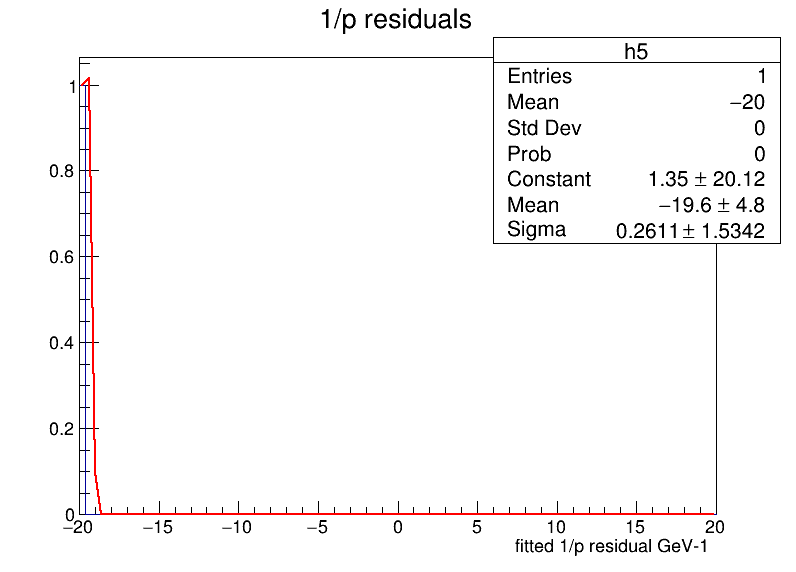

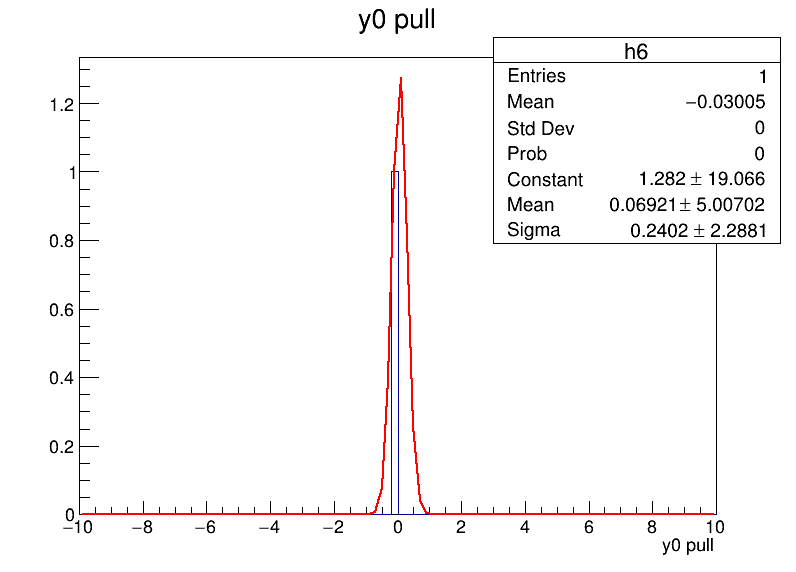

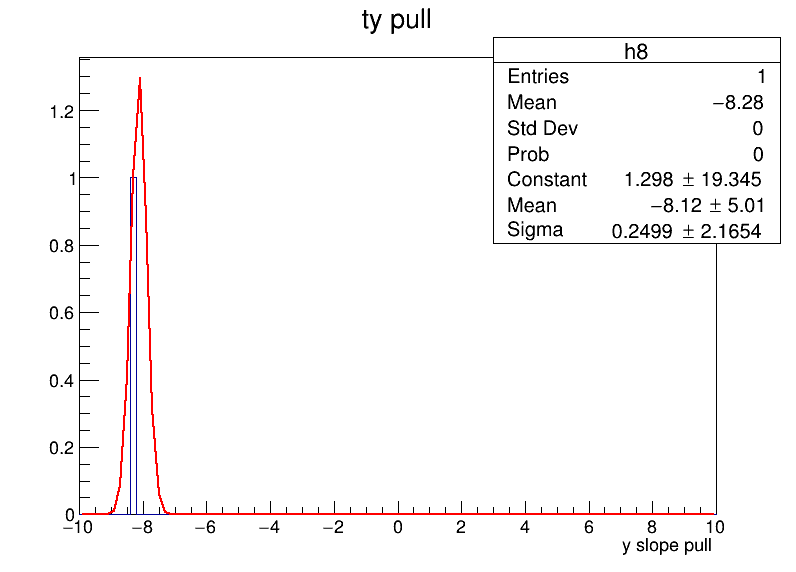

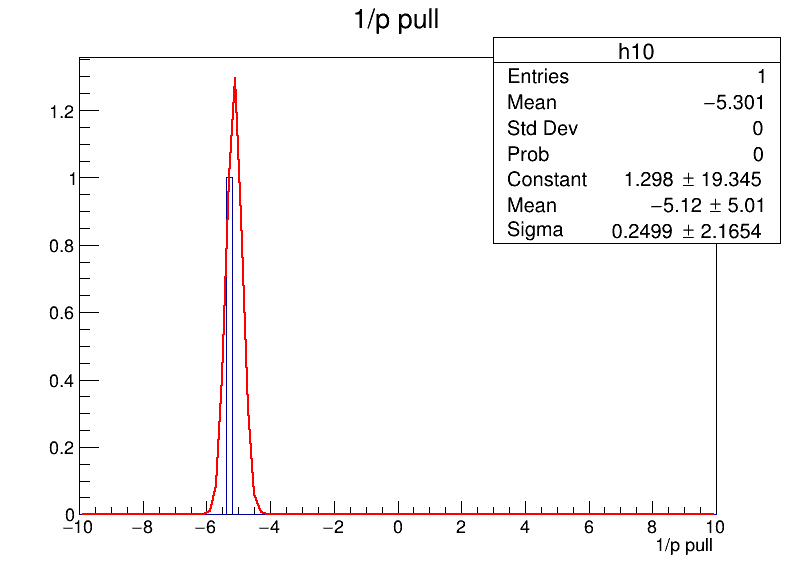

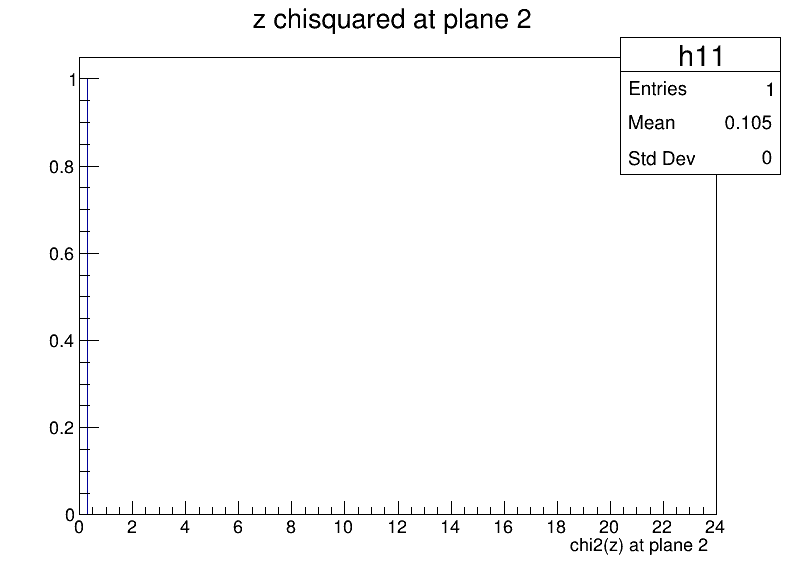

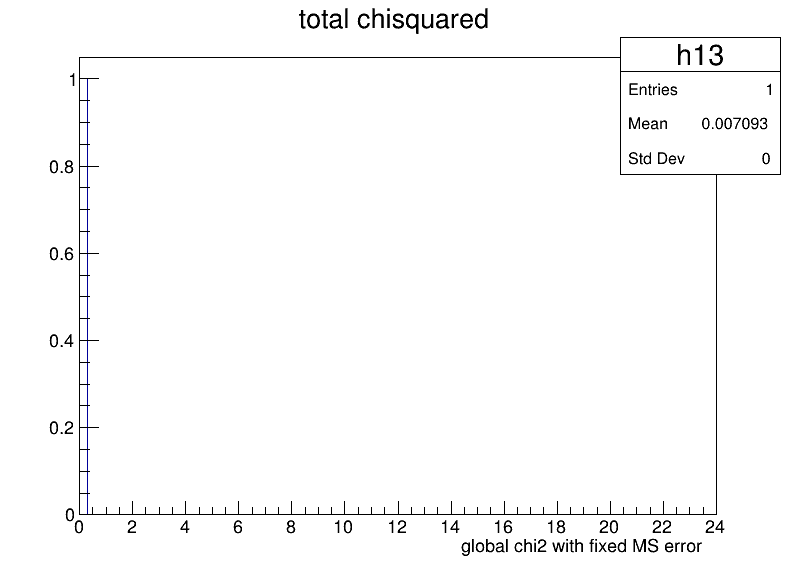

In [19]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()